In [71]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
%matplotlib inline

In [2]:
path = os.path.expanduser('~/Data_607_Final_Project') # Your file must have the same name.
os.chdir(path) # Change this to your working directory
train = pd.read_json('~/DATA602_Final_Project/data/processed/train.json')

In [3]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [4]:
train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')

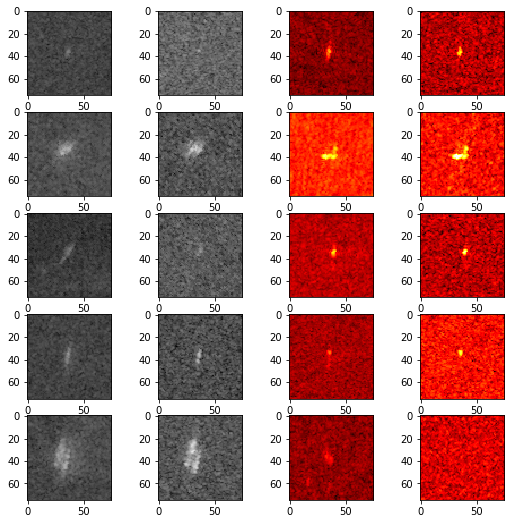

In [5]:
icebergs = train[train.is_iceberg==1]
ships = train[train.is_iceberg==0]

# Plot band_1 and band_2, gray for icebergs, hot for not iceberg
fig = plt.figure(1, figsize=(9, 9))
for i in range(5):
    ax = fig.add_subplot(5, 4, 4*i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,0]),(75,75))  # HH
    ax.imshow(arr,cmap='gray', vmin=-39, vmax=21)
    ax = fig.add_subplot(5, 4, 4*i+2)
    arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))  # HV
    ax.imshow(arr,cmap='gray', vmin=-39, vmax=-3)
    ax = fig.add_subplot(5, 4, 4*i+3)
    arr = np.reshape(np.array(ships.iloc[i,0]),(75,75))  # HH
    ax.imshow(arr,cmap='hot', vmin=-39, vmax=21)
    ax = fig.add_subplot(5, 4, 4*i+4)
    arr = np.reshape(np.array(ships.iloc[i,1]),(75,75))  # HV
    ax.imshow(arr,cmap='hot', vmin=-39, vmax=-3)
    
fig.savefig('bergs_and_ships.png')

In [40]:
from scipy import ndimage
gauss_denoised = ndimage.gaussian_filter(arr, 2)

# Denoise steps:
1. Use a de-noise algorithm like: http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_photo/py_non_local_means/py_non_local_means.html
1. Correct for brighter pictures with the mean: http://yeephycho.github.io/2016/08/03/normalizations_in_neural_networks/ It may be useful to use the equalized algorithm.
1. Take the first derivative of each image: https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python
1. Look at combing two bands into one image (e.g, just concatinating the strings). Maybe do this step first.
1. Set up data in a way that TF or sklearn can work with.
1. Train/Test split
1. Train Data
1. Cross Validate
1. Run on Kaggle test data

This is what the unedited images look like:

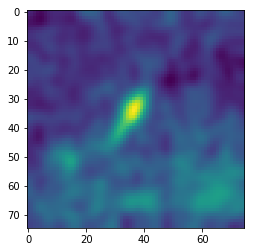

In [7]:
arr = np.reshape(np.array(icebergs.iloc[2,0]),(75,75))
gauss_denoised = ndimage.gaussian_filter(arr, 2)
imgplot = plt.imshow(gauss_denoised)

This is what the images look like if we merge them together (more efficent for training purposes).

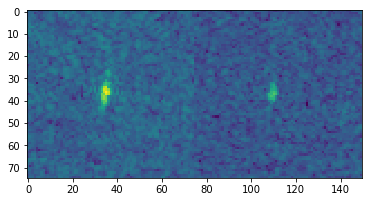

In [8]:
temp = np.concatenate((np.reshape(np.array(train.iloc[0,0]),(75,75)), 
                       np.reshape(np.array(train.iloc[0,1]),(75,75))), axis =1)
#original
imgplot = plt.imshow(temp)

This is what it looks like if we use a gaussian filter to denoise the images. Fewer lines, but less distict.
It may be worth looking at different options to denoise. 

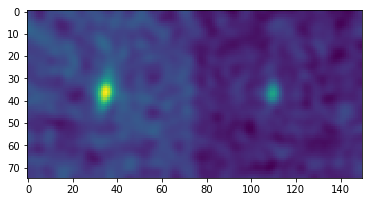

In [43]:

gauss_denoised = ndimage.gaussian_filter(temp, 2)
imgplot = plt.imshow(gauss_denoised)

This is the code to take the first derivative of the image.

More explanation needed here.

In [42]:
xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
from scipy import signal
temp1 = signal.convolve2d(temp,xder,mode='valid')

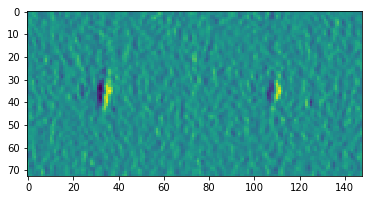

In [11]:
imgplot = plt.imshow(temp1)

Here is the code perform all the pre processing over the data frame.

It saves the results in an np array which is great for other ML libraries.

In [58]:
def pre_process(df):
    imgs = []
    xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    for i, row in df.iterrows():
        # Concatinate square images to one 75 x 150 pixle image. 
        concat = np.concatenate((np.reshape(np.array(train.iloc[i,0]),(75,75)), 
                   np.reshape(np.array(train.iloc[i,1]),(75,75))), axis =1)
        # Denoise image
        gauss_denoised = ndimage.gaussian_filter(temp, 2)
        # Take first derivative. 
        deriv = signal.convolve2d(gauss_denoised, xder, mode= 'valid')
        # Append to array
        imgs.append(deriv)

    return np.array(imgs)


Xtrain = pre_process(train) # Training data
Ytrain = np.array(train['is_iceberg']) # Labels. (Data must remain in this order to not misclassify.)

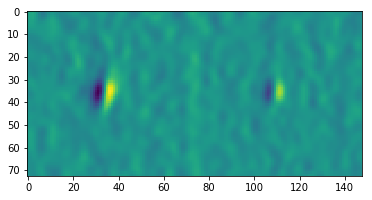

In [59]:
imgplot = plt.imshow(Xtrain[5])

In [14]:
Xtrain.shape

(1604, 73, 148)

In [92]:
square = np.zeros((32, 32))
square[10:-10, 10:-10] = 1
np.random.seed(2)
x, y = (32*np.random.random((2, 20))).astype(np.int)
square[x, y] = 1

open_square = ndimage.binary_opening(Xtrain[3])

eroded_square = ndimage.binary_erosion(square)
reconstruction = ndimage.binary_propagation(eroded_square, mask=square)


In [96]:
arr = Xtrain[3] #np.reshape(np.array(icebergs.iloc[2,0]),(75,75))
sx = ndimage.sobel(arr, axis=0, mode='constant')
sy = ndimage.sobel(arr, axis=1, mode='constant')
sob = np.hypot(sx, sy)

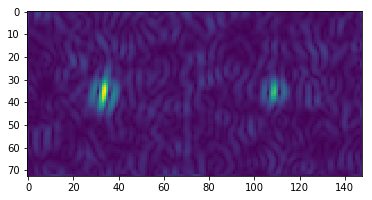

In [99]:
implot = plt.imshow(sob)

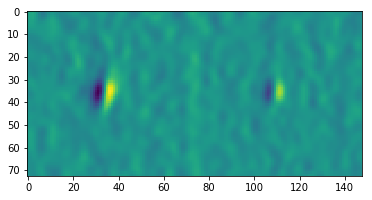

In [100]:
implot = plt.imshow(Xtrain[3])

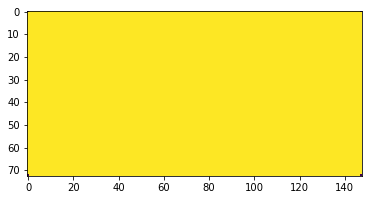

In [90]:
imgplot = plt.imshow(open_square)

In [69]:
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering


labels = spectral_clustering(np.array(train.iloc[0,0]),(75,75), n_clusters=1, eigen_solver='arpack')
label_im = -np.ones(mask.shape)
label_im[mask] = labels

TypeError: spectral_clustering() got multiple values for argument 'n_clusters'

In [60]:
Xtrain[0]

array([[ 2.83655648,  4.22755992,  4.44901935, ..., -3.5214651 ,
        -3.64444425, -2.8322027 ],
       [ 2.75111622,  4.1171436 ,  4.3629311 , ..., -3.08211084,
        -2.93389695, -2.17605139],
       [ 2.65483495,  3.93598516,  4.14400678, ..., -2.69825755,
        -2.18793196, -1.44903287],
       ..., 
       [-0.30485767, -0.77436675, -0.94947973, ..., -2.98255777,
        -2.5006868 , -1.53984677],
       [-0.35450037, -0.80871598, -1.05903264, ..., -2.68128017,
        -2.10566783, -1.1804791 ],
       [-0.44937109, -0.90028411, -1.22104314, ..., -2.41818534,
        -1.73356534, -0.82850994]])

In [15]:
Ytrain.shape

(1604,)

Un-processed images of icebergs:

In [31]:
def reshapedDF(df):
    imgs = []
    xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    for i, row in df.iterrows():
        # Concatinate square images to one 75 x 150 pixle image. 
        concat = np.concatenate((np.reshape(np.array(train.iloc[i,0]),(75,75)), 
                   np.reshape(np.array(train.iloc[i,1]),(75,75))), axis =1)
        
        # Append to array
        imgs.append(concat)

    return np.array(imgs)

In [22]:
icebersOrig = reshapedDF(icebergs)
shipsOrig = reshapedDF(ships)

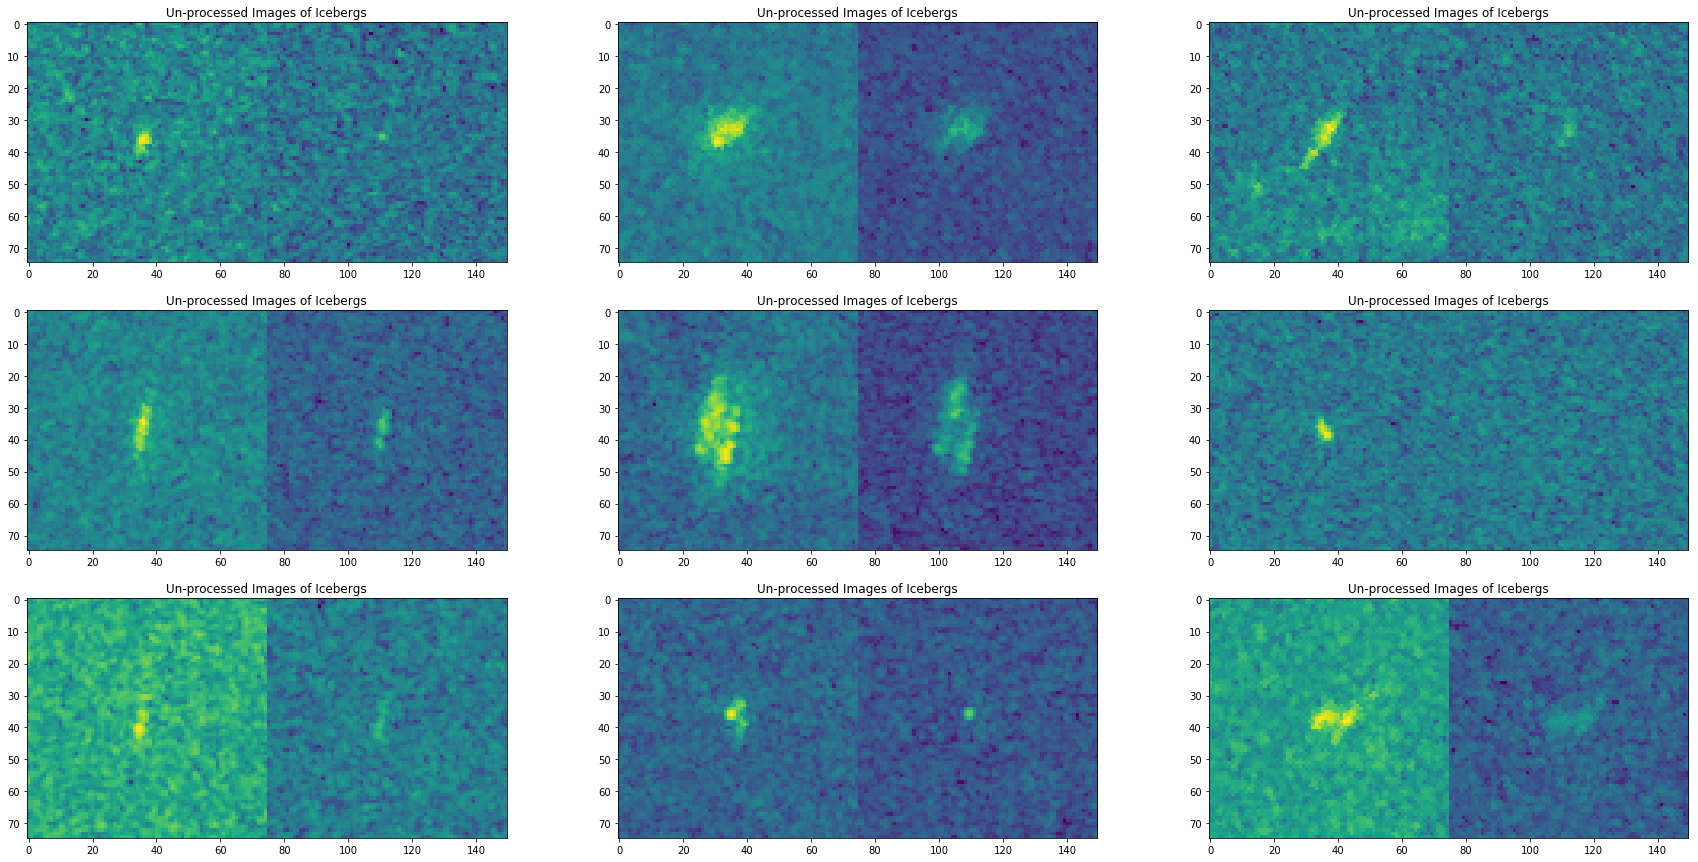

In [26]:
# Plot band_1
fig = plt.figure(1,figsize=(30,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = icebersOrig[i]
    ax.imshow(arr)
    ax.set_title('Un-processed Images of Icebergs')
    
plt.show()

Un-processed images of ships:

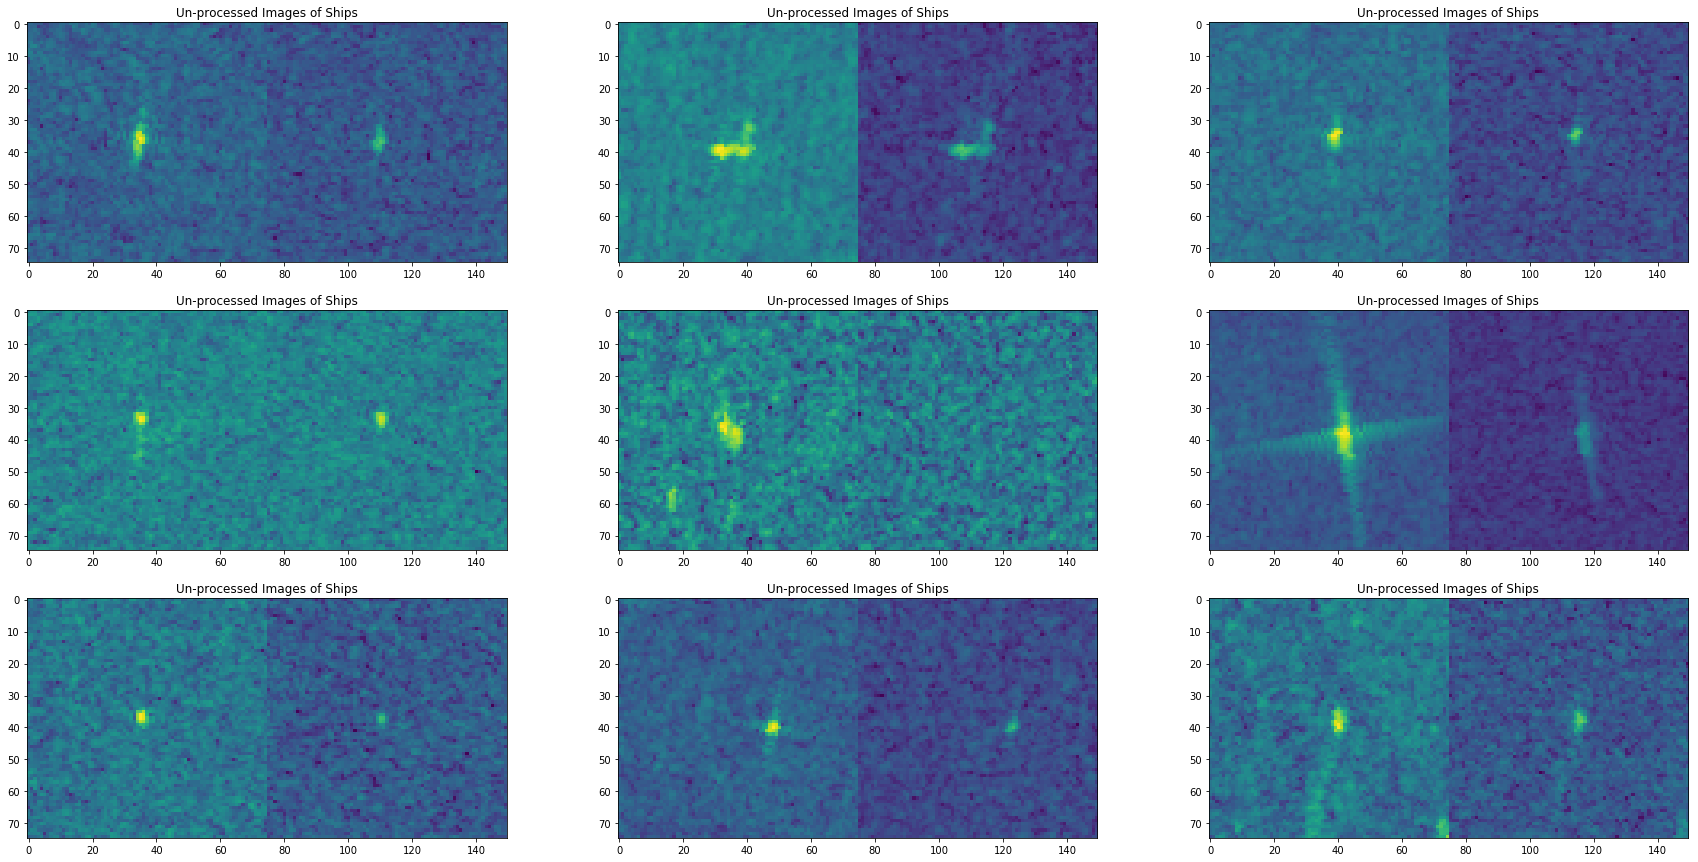

In [25]:
# Plot band_1
fig = plt.figure(1,figsize=(30,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = shipsOrig[i]
    ax.imshow(arr)
    ax.set_title('Un-processed Images of Ships')
    
plt.show()

In [27]:
icebergs2 = pre_process(icebergs)
ships2 = pre_process(ships)


Processed images of Icebergs:

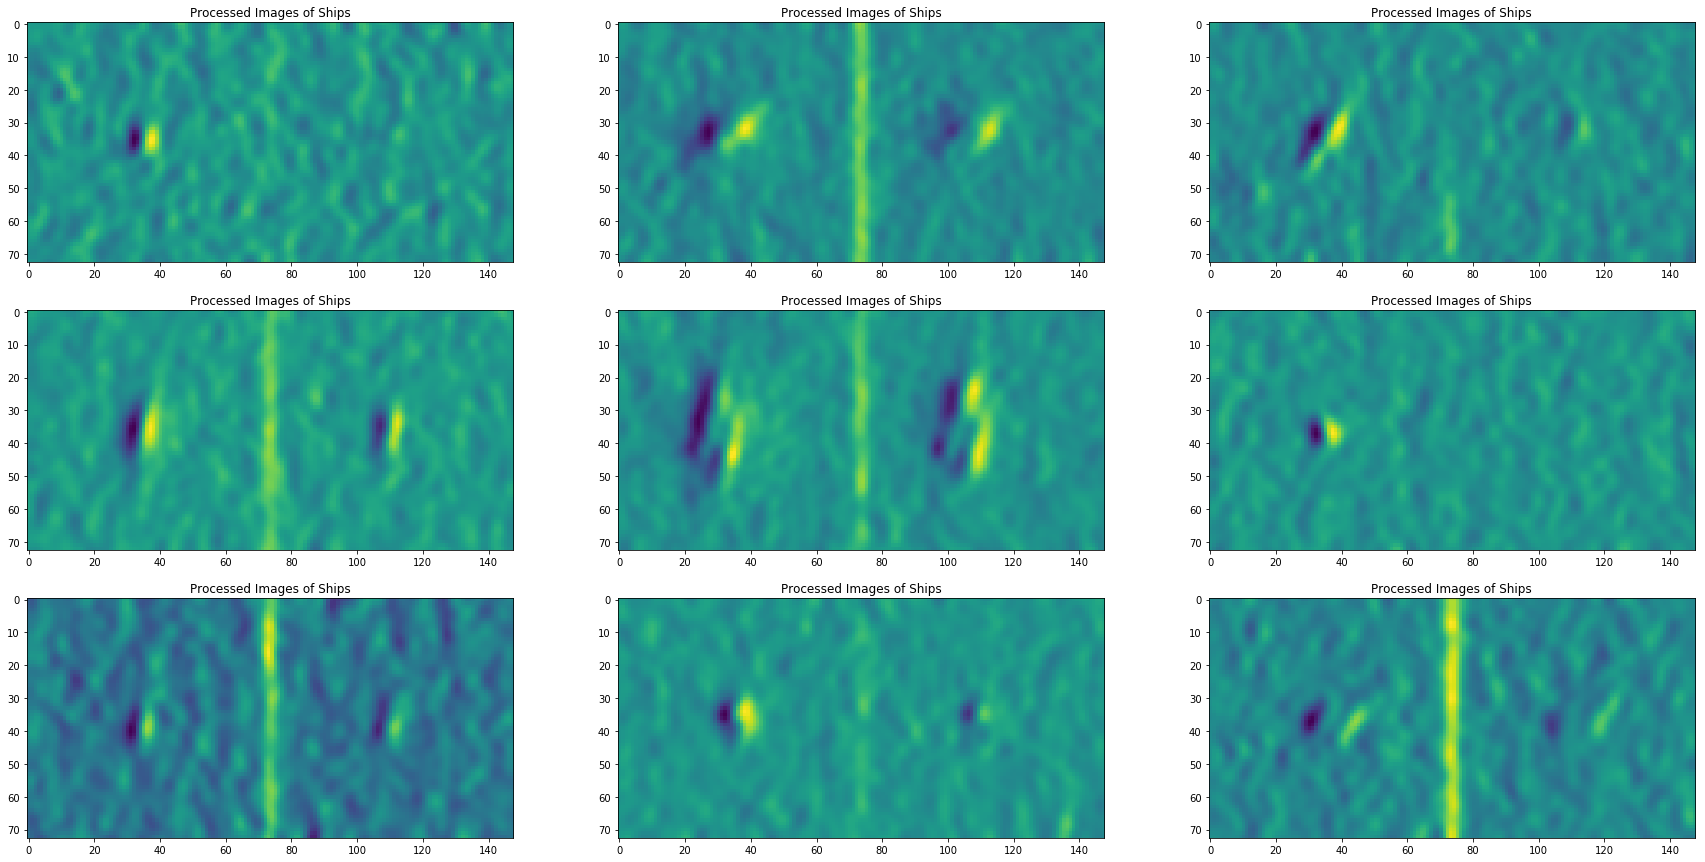

In [29]:
# Plot band_1
fig = plt.figure(1,figsize=(30,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = icebergs2[i]
    ax.imshow(arr)
    ax.set_title('Processed Images of Ships')
    
plt.show()

Processed Images of Ships

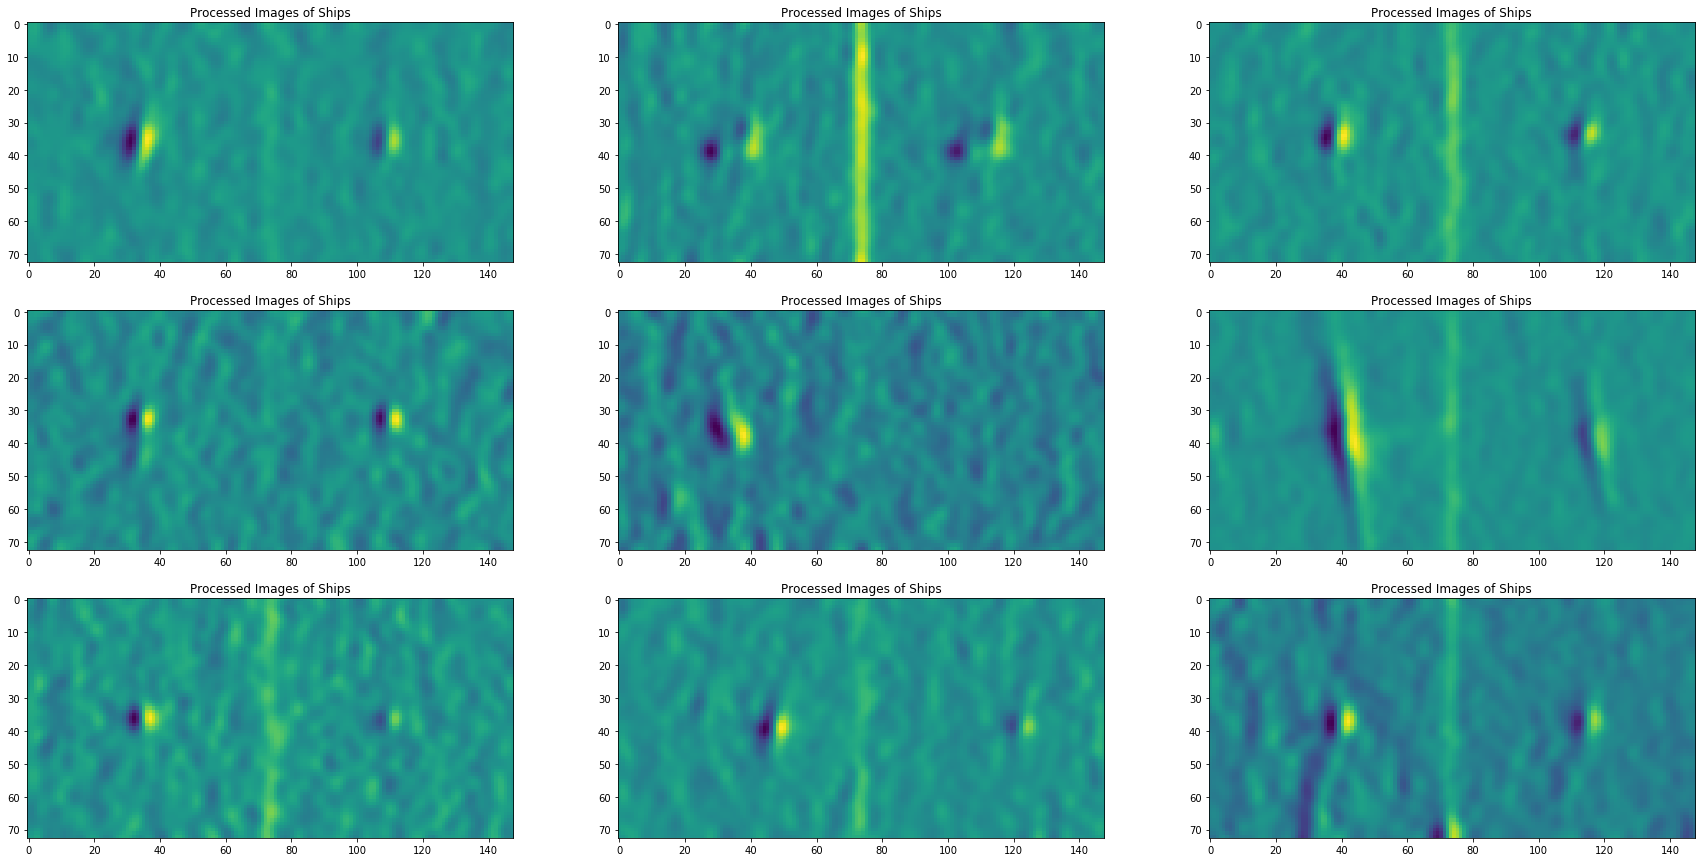

In [30]:
# Plot band_1
fig = plt.figure(1,figsize=(30,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = ships2[i]
    ax.imshow(arr)
    ax.set_title('Processed Images of Ships')
    
plt.show()

In [36]:
icebergsArr.shape


(5, 6)

In [64]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

In [28]:
def getModel():
    #Build keras model
    
    model=Sequential()
    
    # CNN 1
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    #CNN 4
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    # You must flatten the data for the dense layers
    model.add(Flatten())

    #Dense 1
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    #Dense 2
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    # Output 
    model.add(Dense(1, activation="sigmoid"))

    optimizer = Adam(lr=0.001, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

model = getModel()
model.summary()

batch_size = 32
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model.fit(Xtr_more, Ytr_more, batch_size=batch_size, epochs=50, verbose=1, 
          callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.25)

model.load_weights(filepath = '.mdl_wts.hdf5')

score = model.evaluate(Xtrain, Ytrain, verbose=1)
print('Train score:', score[0])
print('Train accuracy:', score[1])

test = pd.read_json('../input/test.json')
test.inc_angle = test.inc_angle.replace('na',0)
Xtest = (get_scaled_imgs(df_test))
pred_test = model.predict(Xtest)

submission = pd.DataFrame({'id': df_test["id"], 'is_iceberg': pred_test.reshape((pred_test.shape[0]))})
print(submission.head(10))

submission.to_csv('submission.csv', index=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

NameError: name 'Xtr_more' is not defined

In [ ]:
train.inc_angle = train.inc_angle.replace('na',0)
idx_tr = np.where(train.inc_angle>0)


Ytrain = Ytrain[idx_tr[0]]
Xtrain = Xtrain[idx_tr[0],...]


# def get_more_images(imgs):
    
#     more_images = []
#     vert_flip_imgs = []
#     hori_flip_imgs = []
      
#     for i in range(0,imgs.shape[0]):
#         a=imgs[i,:,:,0]
#         b=imgs[i,:,:,1]
#         c=imgs[i,:,:,2]
        
#         av=cv2.flip(a,1)
#         ah=cv2.flip(a,0)
#         bv=cv2.flip(b,1)
#         bh=cv2.flip(b,0)
#         cv=cv2.flip(c,1)
#         ch=cv2.flip(c,0)
        
#         vert_flip_imgs.append(np.dstack((av, bv, cv)))
#         hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
#     v = np.array(vert_flip_imgs)
#     h = np.array(hori_flip_imgs)
       
#     more_images = np.concatenate((imgs,v,h))
    
#     return more_images


# Xtr_more = get_more_images(Xtrain) 
# Ytr_more = np.concatenate((Ytrain,Ytrain,Ytrain))



# def get_more_images(imgs):
    
#     more_images = []
#     vert_flip_imgs = []
#     hori_flip_imgs = []
      
#     for i in range(0,imgs.shape[0]):
#         a=imgs[i,:,:,0]
#         b=imgs[i,:,:,1]
#         c=imgs[i,:,:,2]
        
#         av=cv2.flip(a,1)
#         ah=cv2.flip(a,0)
#         bv=cv2.flip(b,1)
#         bh=cv2.flip(b,0)
#         cv=cv2.flip(c,1)
#         ch=cv2.flip(c,0)
        
#         vert_flip_imgs.append(np.dstack((av, bv, cv)))
#         hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
#     v = np.array(vert_flip_imgs)
#     h = np.array(hori_flip_imgs)
       
#     more_images = np.concatenate((imgs,v,h))
    
#     return more_images

# Ytr_more = np.concatenate((Ytrain,Ytrain,Ytrain))


def getModel():
    #Build keras model
    
    model=Sequential()
    
    # CNN 1
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    #CNN 4
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    # You must flatten the data for the dense layers
    model.add(Flatten())

    #Dense 1
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    #Dense 2
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    # Output 
    model.add(Dense(1, activation="sigmoid"))

    optimizer = Adam(lr=0.001, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

model = getModel()
model.summary()

batch_size = 32
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model.fit(Xtr_more, Ytr_more, batch_size=batch_size, epochs=50, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.25)

model.load_weights(filepath = '.mdl_wts.hdf5')

score = model.evaluate(Xtrain, Ytrain, verbose=1)
print('Train score:', score[0])
print('Train accuracy:', score[1])

test = pd.read_json('../input/test.json')
test.inc_angle = test.inc_angle.replace('na',0)
Xtest = (get_scaled_imgs(df_test))
pred_test = model.predict(Xtest)

submission = pd.DataFrame({'id': df_test["id"], 'is_iceberg': pred_test.reshape((pred_test.shape[0]))})
print(submission.head(10))

submission.to_csv('submission.csv', index=False)

In [ ]:
import pandas as pd # Used to open CSV files 
import numpy as np # Used for matrix operations
import cv2 # Used for image augmentation
np.random.seed(1234) 


from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

path = os.path.expanduser('~/Data_607_Final_Project') # Your file must have the same name.
os.chdir(path) # Change this to your working directory
df_train = pd.read_json('~/DATA602_Final_Project/data/processed/train.json')

#df_train = pd.read_json('../input/train.json') # this is a dataframe


def get_scaled_imgs(df):
    imgs = []
    
    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        
        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        imgs.append(np.dstack((a, b, c)))

    return np.array(imgs)


Xtrain = get_scaled_imgs(df_train)
Ytrain = np.array(df_train['is_iceberg'])


df_train.inc_angle = df_train.inc_angle.replace('na',0)
idx_tr = np.where(df_train.inc_angle>0)


Ytrain = Ytrain[idx_tr[0]]
Xtrain = Xtrain[idx_tr[0],...]


def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images


Xtr_more = get_more_images(Xtrain) 
Ytr_more = np.concatenate((Ytrain,Ytrain,Ytrain))



def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images

Ytr_more = np.concatenate((Ytrain,Ytrain,Ytrain))


def getModel():
    #Build keras model
    
    model=Sequential()
    
    # CNN 1
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    #CNN 4
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    # You must flatten the data for the dense layers
    model.add(Flatten())

    #Dense 1
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    #Dense 2
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    # Output 
    model.add(Dense(1, activation="sigmoid"))

    optimizer = Adam(lr=0.001, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

model = getModel()
model.summary()

batch_size = 32
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model.fit(Xtr_more, Ytr_more, batch_size=batch_size, epochs=50, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.25)

model.load_weights(filepath = '.mdl_wts.hdf5')

score = model.evaluate(Xtrain, Ytrain, verbose=1)
print('Train score:', score[0])
print('Train accuracy:', score[1])

df_test = pd.read_json('../input/test.json')
df_test.inc_angle = df_test.inc_angle.replace('na',0)
Xtest = (get_scaled_imgs(df_test))
pred_test = model.predict(Xtest)

submission = pd.DataFrame({'id': df_test["id"], 'is_iceberg': pred_test.reshape((pred_test.shape[0]))})
print(submission.head(10))

submission.to_csv('submission.csv', index=False)